In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from numba import njit
from numba.types import intc, CPointer, float64
from numba import cfunc, carray, jit
from scipy import LowLevelCallable
import pandas as pd

from scipy.integrate import quad
from scipy import interpolate
from scipy.integrate import quad
from TO_sim.Get_2ndR_NORM import get_r_rp,Make_R_function
from parfor import parfor
from tqdm.notebook import tqdm

In [3]:
def jit_integrand_function(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        values = carray(xx, n)
        return jitted_function(values[0], values[1])
    return LowLevelCallable(wrapped.ctypes)

def jit_integrand_function2(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        if n < 5:
            raise ValueError("Not enough parameters passed to function.")
        values = carray(xx, n)  # 전달된 모든 파라미터를 포함하는 배열
        return jitted_function(values[0], values[1], values[2], values[3],values[4])
    
    return LowLevelCallable(wrapped.ctypes)


def jit_integrand_function3(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        if n < 5:
            raise ValueError("Not enough parameters passed to function.")
        values = carray(xx, n)  # 전달된 모든 파라미터를 포함하는 배열
        return jitted_function(values[0], values[1], values[2], values[3],values[4])
    
    return LowLevelCallable(wrapped.ctypes)



@njit
def g(x, mean, std):
    return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)

@njit
def g_sec(x,Or,Om):
    std = 1
    mean = -Or
    g = (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    dO = abs(Or-Om)
    return np.where(x<-dO,1e-6,g)

@jit_integrand_function2
def integrand_Rl(x, X,O_O,O_p,m):
    return g(x,O_O,O_p)*np.sqrt(1-(x/X)**2)

@jit_integrand_function2
def integrand_Rd(x, X,O_O,O_p,m):
    if m == 0:
        return 0
    else:
        return X/(2*(m*x**2+1/m))*g(x,O_O,O_p)

@jit_integrand_function2
def integrand_Rl2(x, X,O_pm,shift_O,m):
    return g_sec(x,O_pm+shift_O,O_pm)*np.sqrt(1-(x/X)**2)

@jit_integrand_function2
def integrand_Rd2(x, X,O_pm,shift_O,m):
    return X/(2*(m*(x+O_pm+shift_O)**2+1/m))*g_sec(x,O_pm+shift_O,O_pm)
    # return 1/(2*(m*(x)**2+1/m))*g_sec(x,O_pm+shift_O,O_pm)


@jit_integrand_function2
def integrand_Rl3(x, X,O_pm,shift_O,m):
    return g(x,0,1)*np.sqrt(1-((x-O_pm-shift_O)/X)**2)


@jit_integrand_function2
def integrand_Rd3(x, X,O_pm,shift_O,m):
    return X/(2*(m*(x-O_pm-shift_O)**2+1/m))*g(x,0,1)

In [4]:
m = 3.9
ms = np.linspace(3.8,10,621)
# @parfor(ms)
def get_Kritical_rd(m):
# rs = np.linspace(0,1,10000)[1:]
    Xs1 = np.logspace(-15,-3,200)
    Xs = np.r_[Xs1,np.linspace(1e-3,100,6001)]

    R0 = np.nan*np.zeros(len(Xs)) # R_0: Lock state oscillator
    RDh = np.nan*np.zeros(len(Xs)) # R_D: Drift oscillators
    OPS = np.nan*np.zeros(len(Xs)) # O_p: Peak frequency of driven oscillator
    
    # Calulate $r_0$ and $r_D$
    for i,X in enumerate(Xs):
        a = 1/np.sqrt(X*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)

        omega_p = b*X
        R0[i],err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
        RDh[i],err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
        OPS[i] = omega_p


    RD = 2*RDh
    R = R0 -RD
    KK = Xs/R
    K_min_arg = np.argmin(KK)
    K_u = KK[K_min_arg:]
    r_u = Xs[K_min_arg:]/K_u
    R_0u = R0[K_min_arg:]
    R_du = -RD[K_min_arg:]
    OPSu = OPS[K_min_arg:]

    R_u = R_0u + R_du
    K_start = KK[K_min_arg]
    Xsu = Xs[K_min_arg:]

    RPS = []
    RP0s = []
    K1p = []
    
    for X,K,r,r0,rd,OP in zip(Xsu,K_u,R_u,R_0u,R_du,OPSu):
        omega_pp = X
        rp = -rd/2
        a = 1/np.sqrt(K*rp*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)
        OPs = b*K*rp

        delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) + K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
        RP_ls,err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
        RP_ds,err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)
        RP = (RP_ls-RP_ds)
        RPS.append(RP)
    RPS = np.array(RPS)
    x, = np.where(RPS+R_du/2>=0)
    # x, = np.where(RPS>=2e-5)
    K_sd = np.nan
    K_su = np.nan
    
    if len(x)>0:
        K_sd = K_u[x[0]]
        K_su = K_u[x[-1]]
    return K_sd,K_su


def get_Kritical_rd_m(m):
# rs = np.linspace(0,1,10000)[1:]
    Xs1 = np.logspace(-15,-3,200)
    Xs = np.r_[Xs1,np.linspace(1e-3,100,6001)]

    R0 = np.nan*np.zeros(len(Xs)) # R_0: Lock state oscillator
    RDh = np.nan*np.zeros(len(Xs)) # R_D: Drift oscillators
    OPS = np.nan*np.zeros(len(Xs)) # O_p: Peak frequency of driven oscillator
    
    # Calulate $r_0$ and $r_D$
    for i,X in enumerate(Xs):
        a = 1/np.sqrt(X*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)

        omega_p = b*X
        R0[i],err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
        RDh[i],err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
        OPS[i] = omega_p


    RD = 2*RDh
    R = R0 -RD
    KK = Xs/R
    K_min_arg = np.argmin(KK)
    K_u = KK[K_min_arg:]
    r_u = Xs[K_min_arg:]/K_u
    R_0u = R0[K_min_arg:]
    R_du = -RD[K_min_arg:]
    OPSu = OPS[K_min_arg:]

    R_u = R_0u + R_du
    K_start = KK[K_min_arg]
    Xsu = Xs[K_min_arg:]

    RPS = []
    RP0s = []
    K1p = []
    
    for X,K,r,r0,rd,OP in zip(Xsu,K_u,R_u,R_0u,R_du,OPSu):
        omega_pp = X
        rp = -rd/2
        a = 1/np.sqrt(K*rp*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)
        OPs = b*K*rp

        delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) - K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
        RP_ls,err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
        RP_ds,err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)
        RP = (RP_ls-RP_ds)
        RPS.append(RP)
    RPS = np.array(RPS)
    x, = np.where(RPS+R_du/2>=0)
    # x, = np.where(RPS>=2e-5)
    K_sd = np.nan
    K_su = np.nan
    
    if len(x)>0:
        K_sd = K_u[x[0]]
        K_su = K_u[x[-1]]
    return K_sd,K_su
# get_Kritical = np.vectorize(get_Kritical)


In [100]:
def get_Kritical_0l(m):
# rs = np.linspace(0,1,10000)[1:]
    Xs1 = np.logspace(-15,-3,200)
    Xs = np.r_[Xs1,np.linspace(1e-3,100,6001)]

    R0 = np.nan*np.zeros(len(Xs)) # R_0: Lock state oscillator
    RDh = np.nan*np.zeros(len(Xs)) # R_D: Drift oscillators
    OPS = np.nan*np.zeros(len(Xs)) # O_p: Peak frequency of driven oscillator
    
    # Calulate $r_0$ and $r_D$
    for i,X in enumerate(Xs):
        a = 1/np.sqrt(X*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)

        omega_p = b*X
        R0[i],err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
        RDh[i],err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
        OPS[i] = omega_p


    RD = 2*RDh
    R = R0 -RD
    KK = Xs/R
    K_min_arg = np.argmin(KK)
    K_u = KK[K_min_arg:]
    r_u = Xs[K_min_arg:]/K_u
    R_0u = R0[K_min_arg:]
    R_du = -RD[K_min_arg:]
    OPSu = OPS[K_min_arg:]

    R_u = R_0u + R_du
    K_start = KK[K_min_arg]
    Xsu = Xs[K_min_arg:]

    RPS = []
    RP0s = []
    K1p = []
    
    for X,K,r,r0,rd,OP in zip(Xsu,K_u,R_u,R_0u,R_du,OPSu):
        omega_pp = X
        rp = 1e-10
        a = 1/np.sqrt(K*rp*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)
        OPs = b*K*rp

        delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) + K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
        RP_ls,err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
        # RP_ds,err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)
        RP = (RP_ls)#-RP_ds)
        RPS.append(RP)
    RPS = np.array(RPS)
    x, = np.where(RPS-rp>=0)
    # x, = np.where(RPS>=2e-5)
    K_sd = np.nan
    K_su = np.nan
    
    if len(x)>0:
        K_sd = K_u[x[0]]
        K_su = K_u[x[-1]]
    return K_sd,K_su

In [49]:
ms1 = np.linspace(3.86,3.87,101)[:-1]
K_sds0 = np.nan * ms1
K_sus0 = np.nan * ms1
for i,m in enumerate(tqdm(ms1)):
    K_sds0[i],K_sus0[i] = get_Kritical_rd(m)

In [50]:
K_sds0 = np.nan * ms1
K_sus0 = np.nan * ms1
for i,m in enumerate(tqdm(ms1)):
    K_sds0[i],K_sus0[i] = get_Kritical(m)

  0%|          | 0/100 [00:00<?, ?it/s]

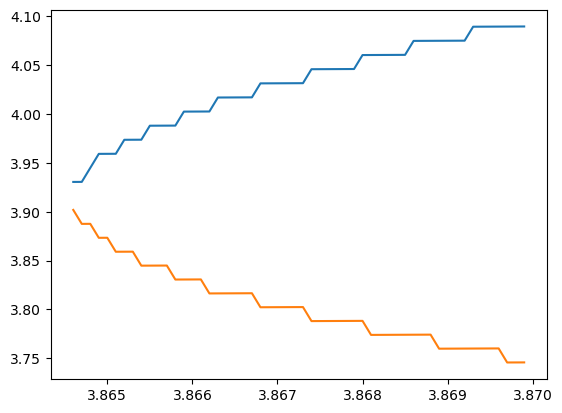

In [51]:
plt.plot(ms1, K_sus0)
plt.plot(ms1, K_sds0)

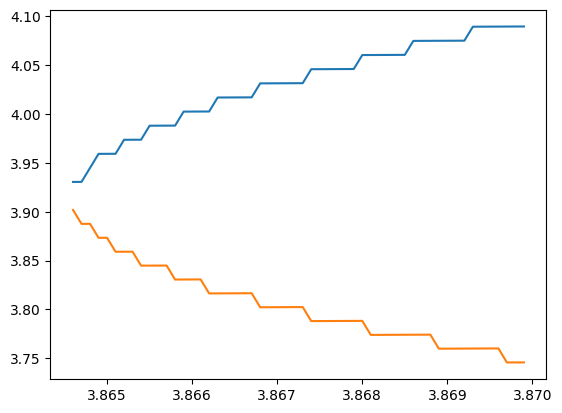

In [19]:
plt.plot(ms1, K_sus0)
plt.plot(ms1, K_sds0)

$$
⟨sin⁡(2𝜔_{(+)} 𝑡 + 𝜃_𝑖 ) ⟩=(𝐾𝑟_+)/(4𝜔_{(+)} (4𝜔_{(+)}^2 𝑚^2+1))→−(𝐾𝑟_+)/(4𝜔_{(+)} (4𝜔_{(+)}^2 𝑚^2+1))
$$

## To prove the solution of $\delta_+$  
```python
delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) - K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
``` 
$\rightarrow$
```python
delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) + K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
``` 


## Graph $r_0$

In [86]:
A = {}
B = {}

In [62]:
K = 4
m = 6.72
# rs = np.linspace(0,1,10000)[1:]
Xs1 = np.logspace(-15,-3,2000)
Xs = np.r_[Xs1,np.linspace(1e-3,60,10001)]

R_ls = []
R_drs = []


for X in Xs:
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)

    omega_p = b*X
    R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
    R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
    R_ls.append(R_l)
    R_drs.append(R_dr)


R0 = np.array(R_ls)
RD = 2*np.array(R_drs)
R = R0 -RD
KK = 1/(R/Xs)
K_min_arg = np.argmin(KK)

K_d = KK[:K_min_arg]
K_u = KK[K_min_arg:]
r_d = Xs[:K_min_arg]/K_d
r_u = Xs[K_min_arg:]/K_u
R_0d = R0[:K_min_arg]
R_0u = R0[K_min_arg:]
R_dd = -RD[:K_min_arg]
R_du = -RD[K_min_arg:]

R_u = R_0u + R_du
R_d = R_0d + R_dd
K_start = KK[K_min_arg]
Xsu = Xs[K_min_arg:]
Xsd = Xs[:K_min_arg]

a = 1/np.sqrt(Xsu*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPS = b*Xsu


a = 1/np.sqrt(Xsd*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPSd = b*Xsd


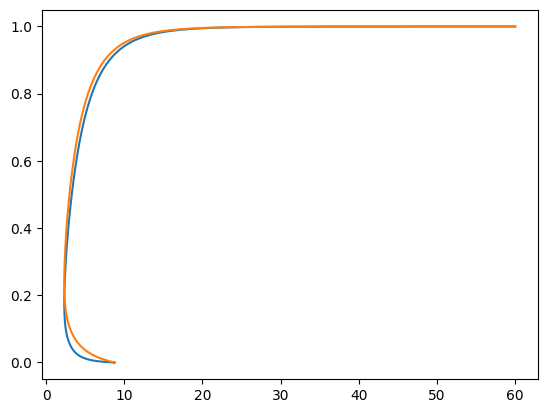

In [56]:
plt.plot(KK,R)
plt.plot(KK,R0)

In [66]:
RP1_u = []
RP1_d = []
RP01_u = []
RP01_d = []

K1p = []
for X,K,r,r0,rd,OP in zip(Xsu,K_u,R_u,R_0u,R_du,OPS):
    rs1 = np.logspace(-6,np.log10(0.01),100)
    rps = np.r_[rs1,np.linspace(0.01,(1-r0)/2,100)] 
    omega_pp = X
    RP_ls = np.nan*rps
    RP_ds = np.nan*rps

    for i,rp in enumerate(rps):
        # OPs = K*rp
        a = 1/np.sqrt(K*rp*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)
        OPs = max(b*K*rp,0)
        
        delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) + K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
        RP_ls[i],err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
        RP_ds[i],err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)
    RP = (RP_ls-RP_ds)
    x, = np.where((RP-rps)>=0)
    # plt.plot(rps,RP-rps)
    
    
    try:
        RP1_u.append(rps[x[-1]])
        RP1_d.append(rps[x[0]])
        RP01_u.append(RP_ls[x[-1]])
        RP01_d.append(RP_ls[x[0]])
        K1p.append(K)
    except:pass

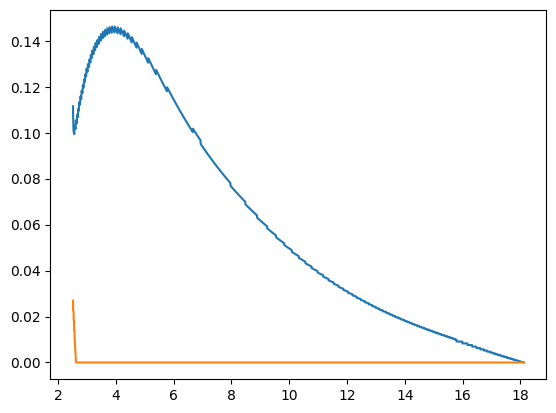

In [67]:
plt.plot(K1p,RP1_u)
plt.plot(K1p,RP1_d)

In [52]:
from scipy.integrate import quad
from scipy.optimize import brentq
import numpy as np

def RP_diff(rp, K, r0, OP, m):
    try:
        a = 1 / np.sqrt(K * rp * m)
        b = 4 / np.pi * a - 0.3056 * a**3
        if a > 1.193: b = 1
        b = min(b, 1)
        OPs = max(b * K * rp, 0)

        delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

        RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=200)
        RP_d, _ = quad(integrand_Rd, OP + delta_P + OPs, np.inf, args=(K * rp, 0, 1, m), limit=200)

        return RP_l - RP_d - rp
    except:
        return np.nan


In [63]:
RP1_d = []
RP1_u = []
RP01_d = []
RP01_u = []
K1p = []
for X, K, r, r0, rd, OP in zip(Xsu, K_u, R_u, R_0u, R_du, OPS):
    # 1. 적당한 간격으로 샘플
    rps = np.r_[np.logspace(-18, -3, 100), np.linspace(0.001, (1 - r0) / 2, 100)]
    diffs = np.array([RP_diff(rp, K, r0, OP, m) for rp in rps])


    # 2. sign change 구간 찾기 (교점 후보)
    sign_change = np.where(np.diff(np.sign(diffs)) != 0)[0]

    try:
        # 첫 번째 교점
        i1 = sign_change[0]
        rp_left = brentq(RP_diff, rps[i1-1], rps[i1+1], args=(K, r0, OP, m))

        # 두 번째 교점
        i2 = sign_change[-1]
        rp_right = brentq(RP_diff, rps[i2-1], rps[i2+1], args=(K, r0, OP, m))

        RP1_d.append(rp_left)
        RP1_u.append(rp_right)

        # RP값도 같이 저장
        RP01_d.append(RP_diff(rp_left, K, r0, OP, m) + rp_left)
        RP01_u.append(RP_diff(rp_right, K, r0, OP, m) + rp_right)
        K1p.append(K)
    except:
        pass


/var/folders/04/8yqbnh3d2js_dgb6f3n2sslm0000gn/T/ipykernel_29329/45424574.py:15: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=200)


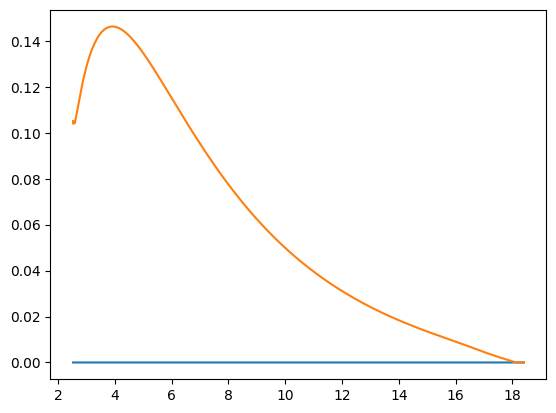

In [64]:
plt.plot(K1p,RP1_d)
plt.plot(K1p,RP1_u)

In [59]:
RP1_u = []
RP1_d = []
RP01_u = []
RP01_d = []

RP_ls = []
RP_ds = []

K1p = []
for i,(X,K,r,r0,rd,OP) in enumerate(zip(Xsu,K_u,R_u,R_0u,R_du,OPS)):
    rs1 = np.logspace(-6,-3,1000)
    rps = np.r_[rs1,np.linspace(1e-3,(1-r0)/2,200)] 
    omega_pp = X

    rp =  1e-11

    a = 1/np.sqrt(K*rp*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)
    OPs = max(b*K*rp,0)
    
    delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) + K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
    RP_l,err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
    RP_d,err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)
    # RP = (RP_ls-RP_ds)
    RP_ls.append(RP_l)
    RP_ds.append(RP_d)
    
RP_ls = np.array(RP_ls)
RP_ds = np.array(RP_ds)
x,=np.where(RP_ls- rp>=0)
K_u[x[0]],K_u[x[-1]]


(2.6380713848776365, 5.224379618020156)

m = 2.78 (2.5758553951028853, 5.4984023485714015)  
m = 2.75 (2.6044076857073715, 5.36382561345667)

In [112]:
A[m],B[m] = K_u,RP_ls- rp

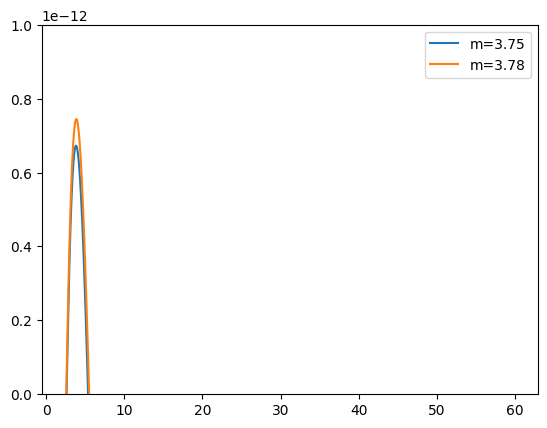

In [113]:
for m in A.keys():
    plt.plot(A[m],B[m],label=f'm={m}')
plt.ylim(0,1e-12)
plt.legend()


2.318630298512065


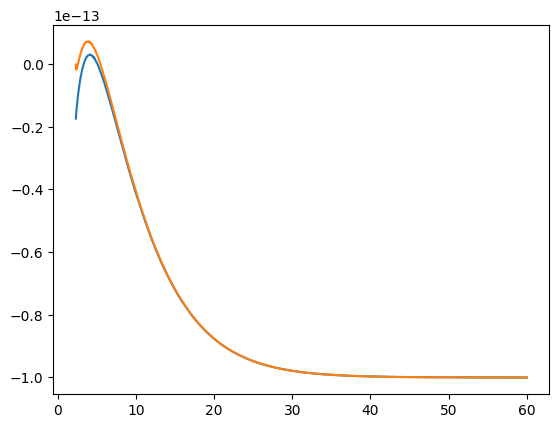

In [85]:
RP_ls = np.array(RP_ls)
RP_ds = np.array(RP_ds)
plt.plot(K_u,RP_ls-RP_ds - rp)
plt.plot(K_u,RP_ls - rp)
print(K_u[0])


# plt.plot(K_u,RP_ls-RP_ds - rp)


In [ ]:
for X,K,r,r0,rd,OP in list(zip(Xsu,K_u,R_u,R_0u,R_du,OPS))[::10]:
    rs1 = np.logspace(-6,-2,100)
    rps = np.r_[rs1,np.linspace(1e-2,(1-r0)/2,200)] 
    omega_pp = X
    RP_ls = np.nan*rps
    RP_ds = np.nan*rps

    for i,rp in enumerate(rps):
        # OPs = K*rp
        a = 1/np.sqrt(K*rp*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)
        OPs = max(b*K*rp,0)
        
        delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) + K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
        RP_ls[i],err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
        RP_ds[i],err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)
    RP = (RP_ls-RP_ds)
    x, = np.where((RP-rps)>=0)
    plt.plot(rps,RP-rps)
    
    # break

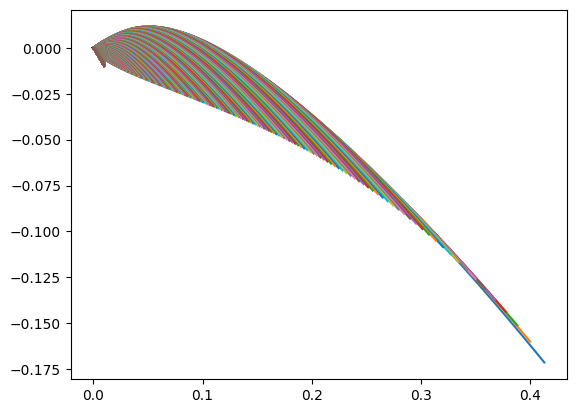

In [126]:
for X,K,r,r0,rd,OP in list(zip(Xsu,K_u,R_u,R_0u,R_du,OPS))[::10]:
    rs1 = np.logspace(-6,-2,100)
    rps = np.r_[rs1,np.linspace(1e-2,(1-r0)/2,200)] 
    omega_pp = X
    RP_ls = np.nan*rps
    RP_ds = np.nan*rps

    for i,rp in enumerate(rps):
        # OPs = K*rp
        a = 1/np.sqrt(K*rp*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)
        OPs = max(b*K*rp,0)
        
        delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) + K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
        RP_ls[i],err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
        RP_ds[i],err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)
    RP = (RP_ls-RP_ds)
    x, = np.where((RP-rps)>=0)
    plt.plot(rps,RP-rps)
    
    # break

In [122]:
np.where(RP-rps>=0)

(array([], dtype=int64),)

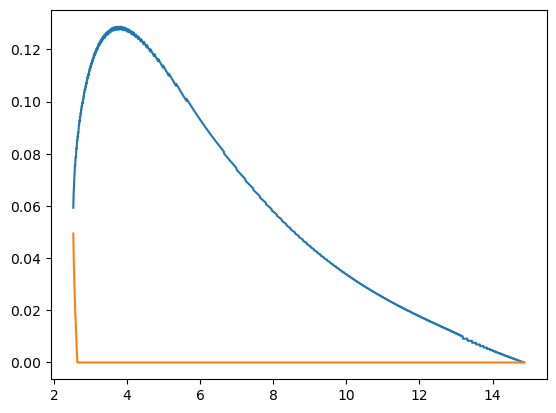

In [85]:
plt.plot(K1p,RP1_u)
plt.plot(K1p,RP1_d)

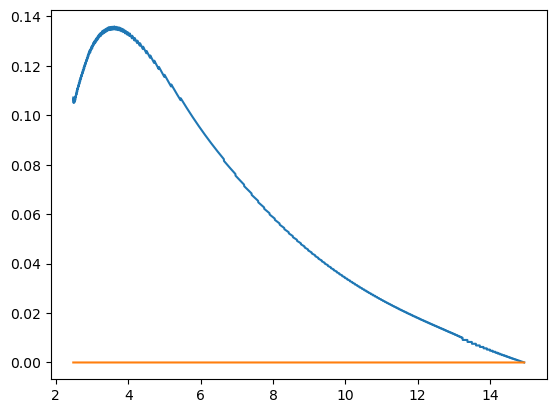

In [87]:
plt.plot(K1p,RP1_u)
plt.plot(K1p,RP1_d)

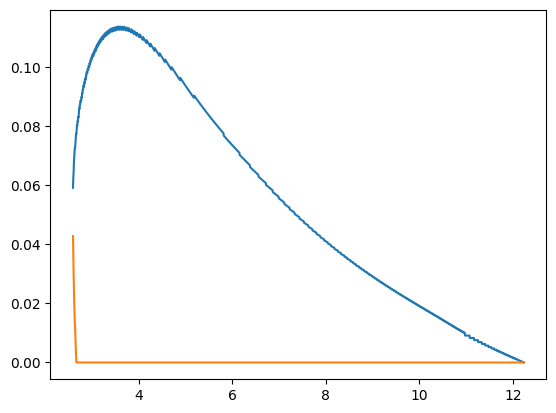

In [129]:
plt.plot(K1p,RP1_u)
plt.plot(K1p,RP1_d)


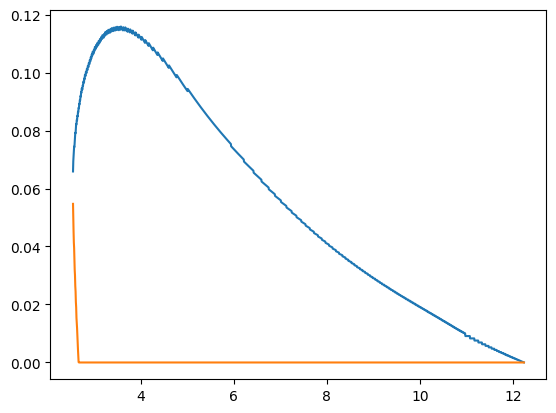

In [127]:
plt.plot(K1p,RP1_u)
plt.plot(K1p,RP1_d)


In [ ]:
F = get_r_Fun(m)

In [ ]:
K = 5
r0 = float(F['u']['R0'](K))
r = float(F['u']['R'](K))
OP = float(F['u']['OPS'](K))
X = K*r

In [64]:
rs1 = np.logspace(-6,-2,100)
rps = np.r_[rs1,np.linspace(1e-2,(1-r0)/2,200)] 
omega_pp = X
RP_ls = np.nan*rps
RP_ds = np.nan*rps

for i,rp in enumerate(rps):
    OPs = K*rp

    delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) + K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
    RP_ls[i],err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
    RP_ds[i],err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)
RP = (RP_ls-RP_ds)
x, = np.where((RP-rps)>=0)

IndexError: index 0 is out of bounds for axis 0 with size 0

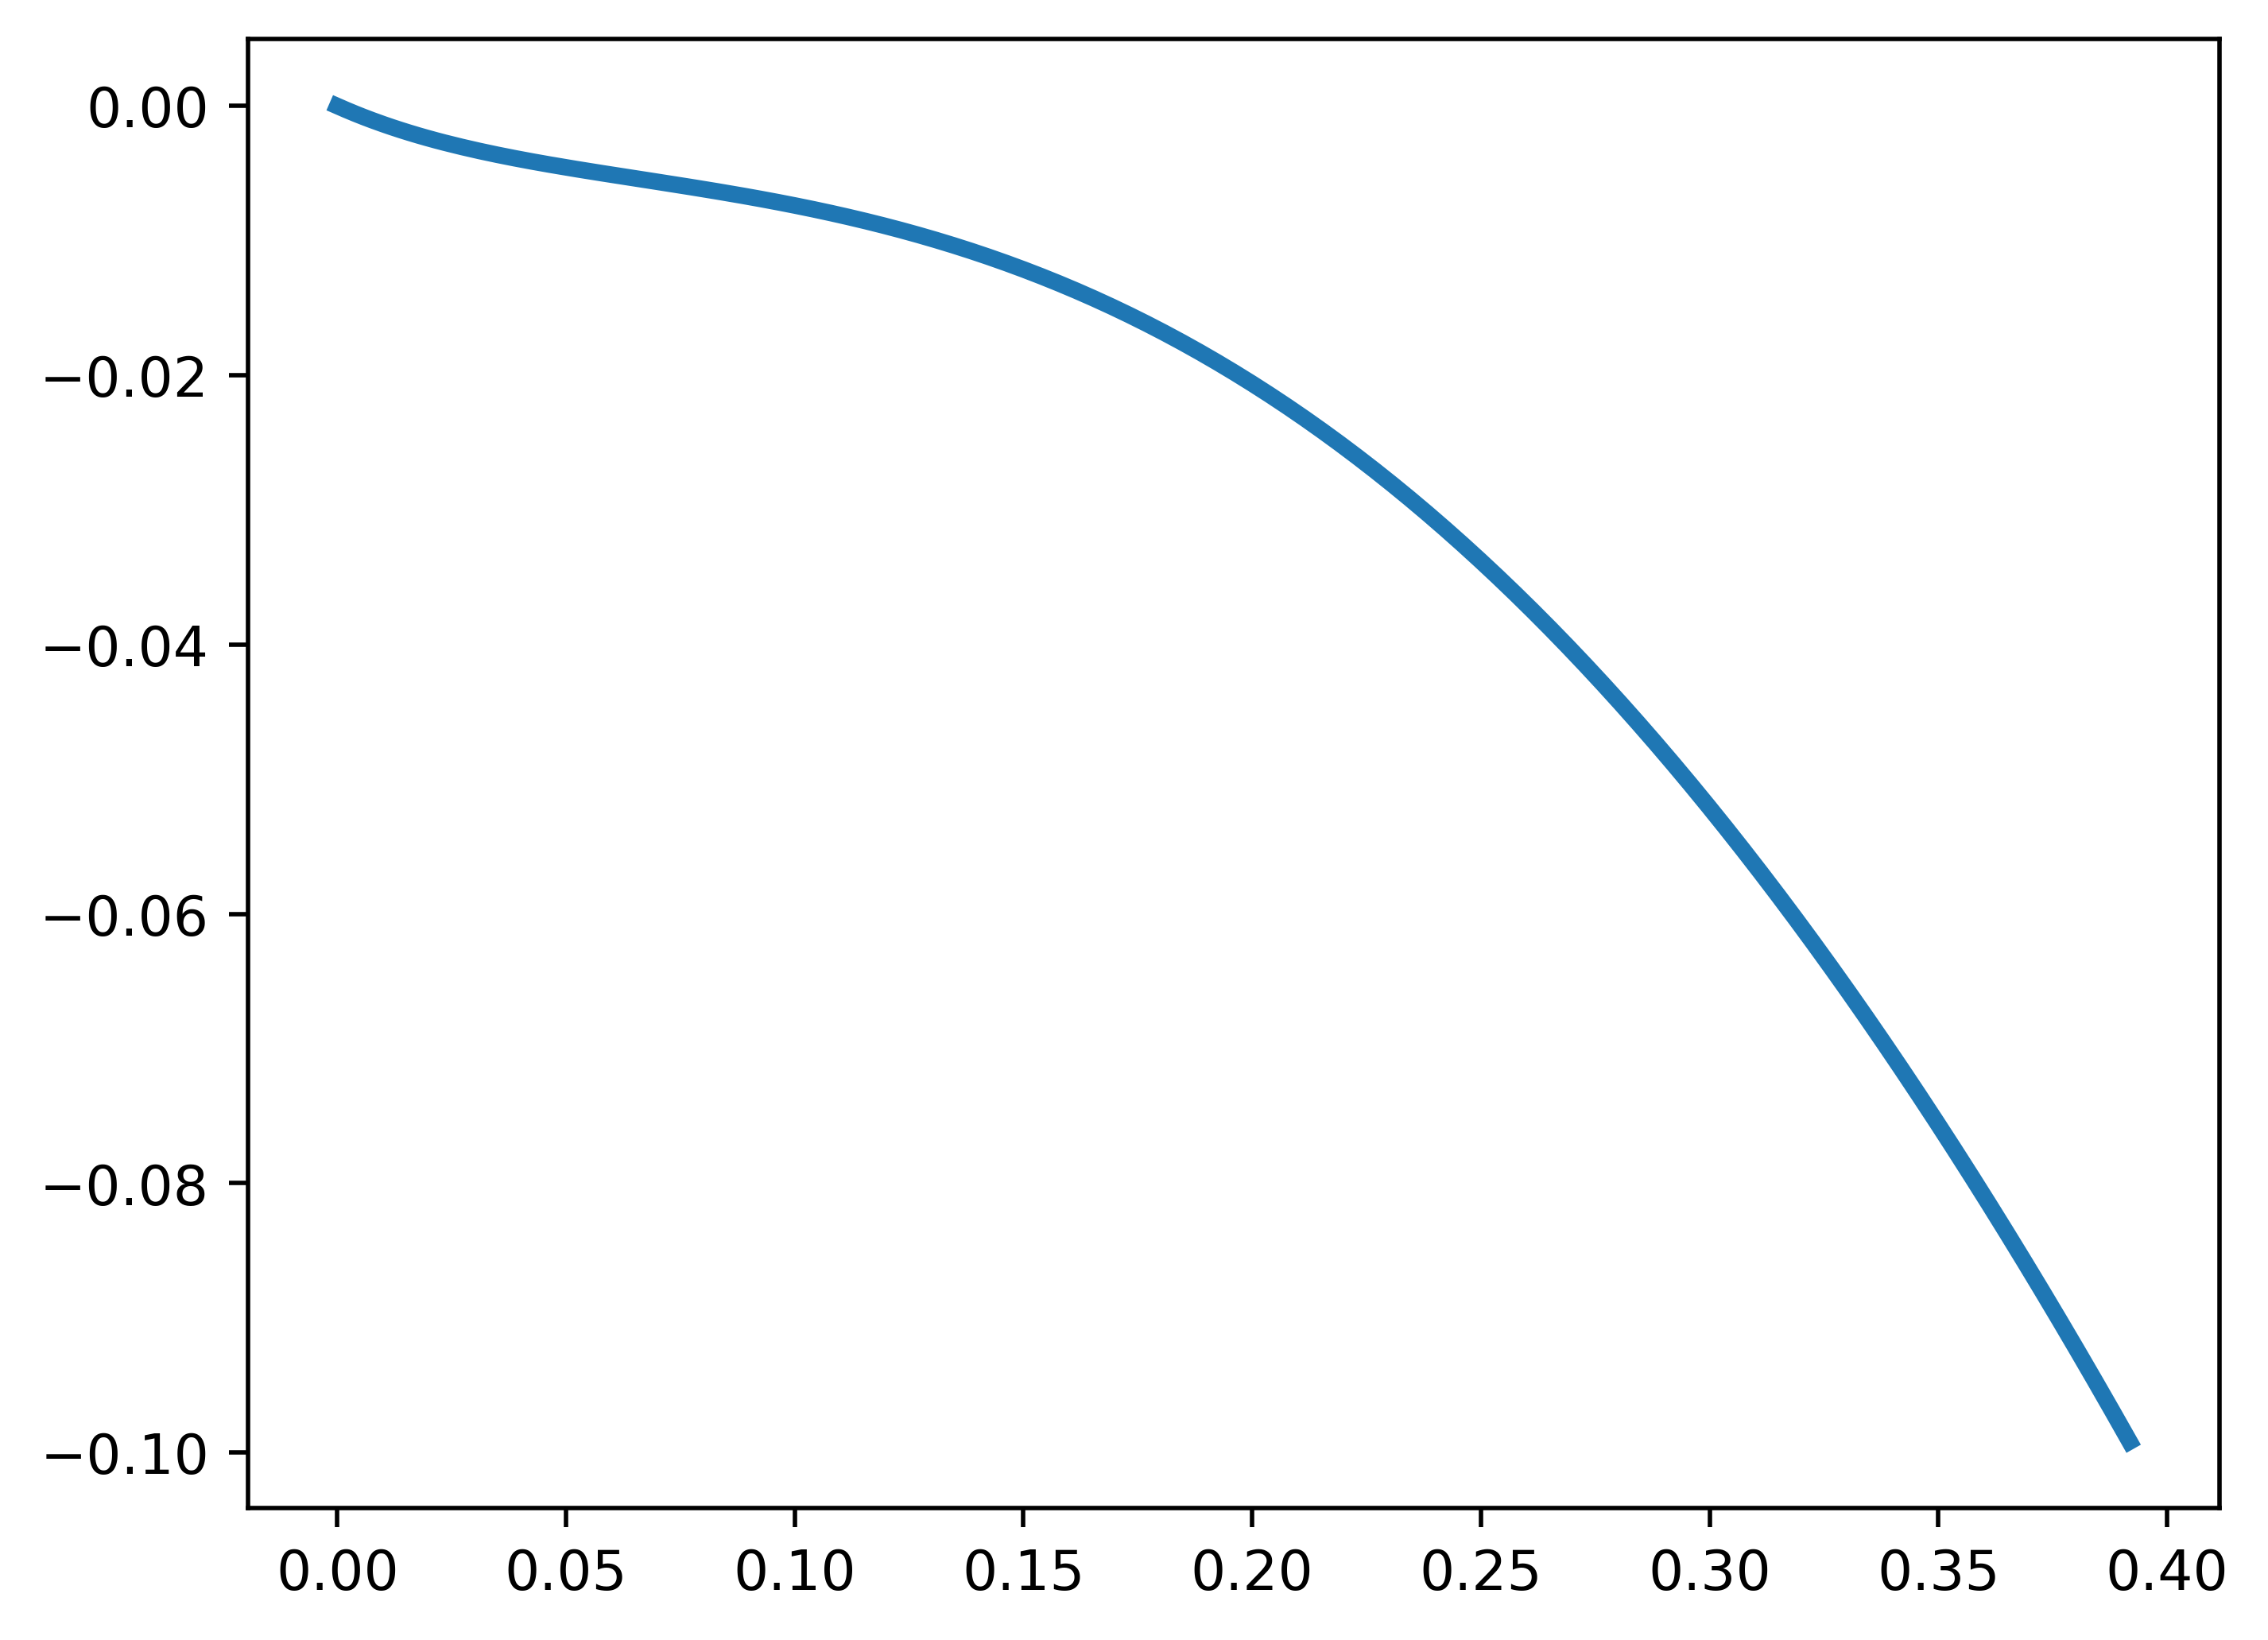

In [65]:
plt.figure(dpi=500)
plt.plot(rps,RP-rps,lw=3)
plt.axvline(rps[x[0]],color='red',ls='--')
plt.axvline(rps[x[-1]],color='red',ls='--')
plt.axhline(0,color='black',ls='--')
# plt.xlim(0,)
plt.xlabel(r'$r_+$',fontsize=15)
plt.ylabel(r'$J(X,r_+)$',fontsize=15)
# plt.title(rf'$X={X:.02f},G(X)={K},m={m}$')

In [119]:
m = 3.9
ms = np.linspace(3.8,10,621)
# @parfor(ms)
def get_Kritical_0(m):
# rs = np.linspace(0,1,10000)[1:]
    Xs1 = np.logspace(-15,-3,200)
    Xs = np.r_[Xs1,np.linspace(1e-3,100,6001)]

    R0 = np.nan*np.zeros(len(Xs)) # R_0: Lock state oscillator
    RDh = np.nan*np.zeros(len(Xs)) # R_D: Drift oscillators
    OPS = np.nan*np.zeros(len(Xs)) # O_p: Peak frequency of driven oscillator
    
    # Calulate $r_0$ and $r_D$
    for i,X in enumerate(Xs):
        a = 1/np.sqrt(X*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)

        omega_p = b*X
        R0[i],err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
        RDh[i],err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
        OPS[i] = omega_p


    RD = 2*RDh
    R = R0 -RD
    KK = Xs/R
    K_min_arg = np.argmin(KK)
    K_u = KK[K_min_arg:]
    r_u = Xs[K_min_arg:]/K_u
    R_0u = R0[K_min_arg:]
    R_du = -RD[K_min_arg:]
    OPSu = OPS[K_min_arg:]

    R_u = R_0u + R_du
    K_start = KK[K_min_arg]
    Xsu = Xs[K_min_arg:]

    RPS = []
    RP0s = []
    K1p = []
    
    for X,K,r,r0,rd,OP in zip(Xsu,K_u,R_u,R_0u,R_du,OPSu):
        omega_pp = X
        rp = 1e-11
        a = 1/np.sqrt(K*rp*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)
        OPs = b*K*rp

        delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) + K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
        RP_ls,err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
        RP_ds,err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)
        RP = (RP_ls-RP_ds)
        RPS.append(RP)
    RPS = np.array(RPS)
    x, = np.where(RPS-rp>=0)
    # x, = np.where(RPS>=2e-5)
    K_sd = np.nan
    K_su = np.nan
    
    if len(x)>0:
        K_sd = K_u[x[0]]
        K_su = K_u[x[-1]]
    return K_sd,K_su

In [161]:
ms3 = np.linspace(3.,10,101)[:-1]
K_sds_Rd3 = np.nan * ms3
K_su_Rd3 = np.nan * ms3
for i,m in enumerate(tqdm(ms3)):
    K_sds_Rd3[i],K_su_Rd3[i] = get_Kritical_rd(m)
l3, = np.where(np.isnan(K_sds_Rd3))
ms2 = np.linspace(ms3[l3[-1]],ms3[l3[-1]+1],101)[:-1]
K_sds_Rd2 = np.nan * ms2
K_su_Rd2 = np.nan * ms2
for i,m in enumerate(tqdm(ms2)):
    K_sds_Rd2[i],K_su_Rd2[i] = get_Kritical_rd(m)
l2, = np.where(np.isnan(K_sds_Rd2))
ms1 = np.linspace(ms2[l2[-1]],ms2[l2[-1]+1],101)[:-1]
K_sds_Rd1 = np.nan * ms1
K_su_Rd1 = np.nan * ms1
for i,m in enumerate(tqdm(ms1)):
    K_sds_Rd1[i],K_su_Rd1[i] = get_Kritical_rd(m)
l1, = np.where(np.isnan(K_sds_Rd1))
ms0 = np.linspace(ms1[l1[-1]],ms1[l1[-1]+1],101)[:-1]
K_sds_Rd0 = np.nan * ms0
K_su_Rd0 = np.nan * ms0
for i,m in enumerate(tqdm(ms0)):
    K_sds_Rd0[i],K_su_Rd0[i] = get_Kritical_rd(m)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [162]:
ms_ = np.r_[ms0,ms1,ms2,ms3]
K_sds_Rd_ = np.r_[K_sds_Rd0,K_sds_Rd1,K_sds_Rd2,K_sds_Rd3]
K_su_Rd_ = np.r_[K_su_Rd0,K_su_Rd1,K_su_Rd2,K_su_Rd3]

l,= np.where(~np.isnan(K_sds_Rd_))
ms_Rd = ms_[l]
K_sds_Rd = K_sds_Rd_[l]
K_sus_Rd = K_su_Rd_[l]

In [72]:
ms1 = np.linspace(3.,6,101)[:-1]
K_sd_Rd_m = np.nan * ms1
K_su_Rd_m = np.nan * ms1
for i,m in enumerate(tqdm(ms1)):
    K_sd_Rd_m[i],K_su_Rd_m[i] = get_Kritical_rd_m(m)

  0%|          | 0/100 [00:00<?, ?it/s]

In [177]:
ms3 = np.linspace(3.,10,101)[:-1]
K_sds3 = np.nan * ms3
K_sus3 = np.nan * ms3
for i,m in enumerate(tqdm(ms3)):
    K_sds3[i],K_sus3[i] = get_Kritical_0(m)
l3, = np.where(np.isnan(K_sds3))
ms2 = np.linspace(ms3[l3[-1]],ms3[l3[-1]+1],101)[:-1]
K_sds2 = np.nan * ms2
K_sus2 = np.nan * ms2
for i,m in enumerate(tqdm(ms2)):
    K_sds2[i],K_sus2[i] = get_Kritical_0(m)
l2, = np.where(np.isnan(K_sds2))
ms1 = np.linspace(ms2[l2[-1]],ms2[l2[-1]+1],101)[:-1]
K_sds1 = np.nan * ms1
K_sus1 = np.nan * ms1
for i,m in enumerate(tqdm(ms1)):
    K_sds1[i],K_sus1[i] = get_Kritical_0(m)
l1, = np.where(np.isnan(K_sds1))
ms0 = np.linspace(ms1[l1[-1]],ms1[l1[-1]+1],101)[:-1]
K_sds0 = np.nan * ms0
K_sus0 = np.nan * ms0
for i,m in enumerate(tqdm(ms0)):
    K_sds0[i],K_sus0[i] = get_Kritical_0(m)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [178]:
ms_ = np.r_[ms0,ms1,ms2,ms3]
K_rp0d_ = np.r_[K_sds0,K_sds1,K_sds2,K_sds3]
K_rp0u_ = np.r_[K_sus0,K_sus1,K_sus2,K_sus3]

l,= np.where(~np.isnan(K_rp0d_)) 
ms_rp0 = ms_[l]
K_rp0d = K_rp0d_[l]
K_rp0u = K_rp0u_[l]

In [168]:
ms3 = np.linspace(3.,10,101)[:-1]
K_sds_l3 = np.nan * ms3
K_sus_l3 = np.nan * ms3
for i,m in enumerate(tqdm(ms3)):
    K_sds_l3[i],K_sus_l3[i] = get_Kritical_0l(m)
l3, = np.where(np.isnan(K_sds_l3))
ms2 = np.linspace(ms3[l3[-1]],ms3[l3[-1]+1],101)[:-1]
K_sds_l2 = np.nan * ms2
K_sus_l2 = np.nan * ms2
for i,m in enumerate(tqdm(ms2)):
    K_sds_l2[i],K_sus_l2[i] = get_Kritical_0l(m)
l2, = np.where(np.isnan(K_sds_l2))
ms1 = np.linspace(ms2[l2[-1]],ms2[l2[-1]+1],101)[:-1]
K_sds_l1 = np.nan * ms1
K_sus_l1 = np.nan * ms1
for i,m in enumerate(tqdm(ms1)):
    K_sds_l1[i],K_sus_l1[i] = get_Kritical_0l(m)
l1, = np.where(np.isnan(K_sds_l1))
ms0 = np.linspace(ms1[l1[-1]],ms1[l1[-1]+1],101)[:-1]
K_sds_l0 = np.nan * ms0
K_sus_l0 = np.nan * ms0
for i,m in enumerate(tqdm(ms0)):
    K_sds_l0[i],K_sus_l0[i] = get_Kritical_0l(m)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [169]:
ms_ = np.r_[ms0,ms1,ms2,ms3]
K_sds_l_ = np.r_[K_sds_l0,K_sds_l1,K_sds_l2,K_sds_l3]
K_sus_l_ = np.r_[K_sus_l0,K_sus_l1,K_sus_l2,K_sus_l3]

l,= np.where(~np.isnan(K_sds_l_))
ms_sds_l = ms_[l]
K_sds_l = K_sds_l_[l]
K_sus_l = K_sus_l_[l]

In [170]:
K_sds_l1

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

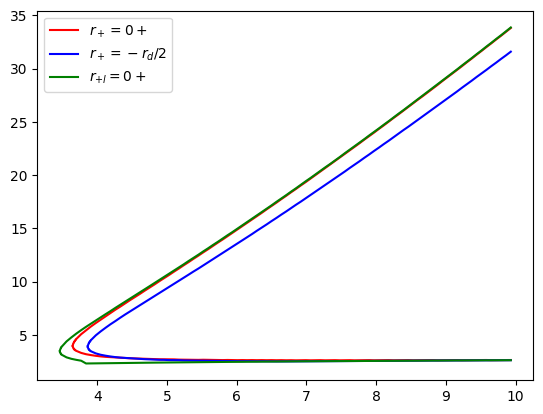

In [179]:
plt.plot(ms_rp0,K_rp0u,color= 'red',label=r'$r_+=0+$')
plt.plot(ms_rp0,K_rp0d,color= 'red')


plt.plot(ms_Rd,K_sus_Rd,color= 'blue',label=r'$r_+=-r_d/2$')
plt.plot(ms_Rd,K_sds_Rd,color= 'blue')


plt.plot(ms_sds_l,K_sus_l,color= 'green',label=r'$r_{+l}=0+$')
plt.plot(ms_sds_l,K_sds_l,color= 'green')

plt.legend()

In [180]:
np.savez('mcs_rp0.npz',ms=ms_rp0,K_u=K_rp0u,K_d=K_rp0d)
np.savez('mcs_Rd.npz',ms=ms_Rd,K_u=K_sus_Rd,K_d=K_sds_Rd)
np.savez('mcs_rpl0.npz',ms=ms_sds_l,K_u=K_sus_l,K_d=K_sds_l)

피크 인덱스: [26]
피크 값: [2.60669484] [3.75]
피크 값: [2.31976559] [3.78]


/Users/gugyoungkim/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gugyoungkim/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


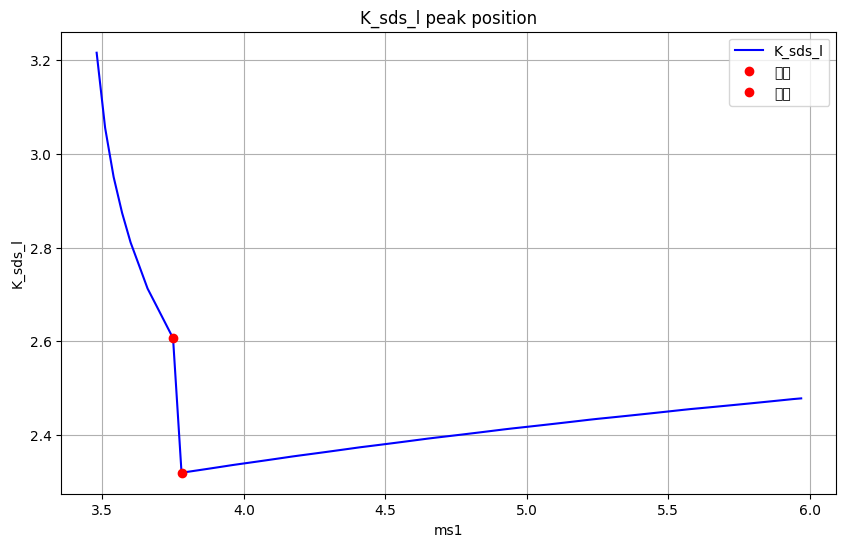

In [102]:
# 배열에서 피크 찾기
from scipy.signal import find_peaks

# K_sds_l 배열에서 피크 찾기
peaks, _ = find_peaks(-K_sds_l)
print("피크 인덱스:", peaks)
print("피크 값:", K_sds_l[peaks-1],ms1[peaks-1])
print("피크 값:", K_sds_l[peaks],ms1[peaks])

# 피크 시각화
plt.figure(figsize=(10, 6))
plt.plot(ms1, K_sds_l, 'b-', label='K_sds_l')
plt.plot(ms1[peaks], K_sds_l[peaks], 'ro', label='피크')
plt.plot(ms1[peaks-1], K_sds_l[peaks-1], 'ro', label='피크')

plt.xlabel('ms1')
plt.ylabel('K_sds_l')
plt.title('K_sds_l peak position')
plt.legend()
plt.grid(True)
plt.show()

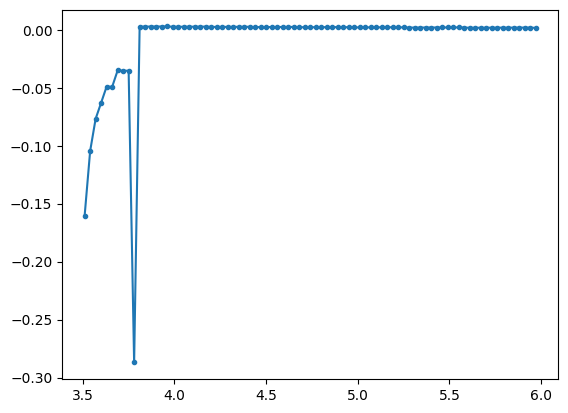

In [103]:
plt.plot(ms1[1:],np.diff(K_sds_l),'.-')
